# Challenge: Lets train a QuickDraw model & Deploy it as an online service
In the following App we will create a [QuickDraw](https://quickdraw.withgoogle.com/) predictor App. The Dataset is available from [GCS](https://quickdraw.withgoogle.com/data) and contains more than **50 million** labeled drawings. Deep-Learning is a fantastic modeling technique to apply to a visual dataset like this. 

## Build a UnionML app
To train a QuickDraw model - we will use the UnionML. This is implemented in [main.py](pictionary_app/main.py) <-- **Click Here**

## Now that the App is written, we can import and execute it in this interactive notebook

Note we will simply train for 2 classes. this is because the model is a deep learning model and training for the large dataset may take too long locally.

In [1]:
from pictionary_app import model

In [2]:
num_classes = 2

model.train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": 1},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)

### So local works, I want to train on larger dataset!
Let us try to train the model on more data. But for this, we need a GPU. (For refernece training for 2 classes take almost 5 minutes on CPU and 5 seconds on GPU)
but, how should we do that?

this is where UnionML shines with the help of flyte in the backend. you can simply change the API from `train` to ``remote_train``

In [2]:
num_classes = 200
num_epochs = 1

execution = model.remote_train(
    hyperparameters={"num_classes": num_classes},
    trainer_kwargs={"num_epochs": num_epochs},
    data_dir="./data",
    max_examples_per_class=10000,
    class_limit=num_classes,
)

Executing quickdraw_classifier.train, execution name: f29d13c6818174191ac2.
Go to https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/f29d13c6818174191ac2 to see the execution in the console.


Now, wait for the execution to complete and then load model from the remote training job. We can easily interact with the fetched model locally to generate predictions.

In [3]:
model.remote_load(execution)

Waiting for execution f29d13c6818174191ac2 to complete...
Done.


### Alright, lets do a Live DEMO!
Lets fetch the trained model ^^ and then using the wonderful library called [gradio](https://gradio.app/) to create an interactive widget to test out the model. 

**Note** UnionML makes it simple to create a webserver using the same ``predict`` method that you wrote as part of ``model``

**Challenge** Draw a smiley face and see if the model understands it!

In [4]:
import gradio as gr

gr.Interface(
    fn=model.predict,
    inputs="sketchpad",
    outputs="label",
    live=True,
    allow_flagging="never",
).launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x158773d30>, 'http://127.0.0.1:7860/', None)

# Challenge: Lets perform a batch prediction on a corpus of doodle drawings
What if we want to run predictions on a large number of precreated doodles. Maybe you got them as a drop from somewhere and want to quickly get answers?

The UnionML API is lacking. But, we know [Flyte](https://flyte.org/) should handle this. But, how can we reuse UnionML trained model from flytekit?

### UnionML is backed by Flytekit
UnionML is backed by flytekit, a general purpose SDK for expressing Flyte workflows. In this section, we define a workflow that uses the model we trained above, and run batch prediction on a larger dataset on the same Flyte backend.


### Let us construct a workflow
** The workflow should look like so**
1. Downloads the available quickdraw categories: `download_quickdraw_dataset`
2. Downloads the quickdraw labeled dataset: `download_quickdraw_dataset`
3. Attempts to label and generate features for randomly selected drawings in the dataset: `generate_input`
4. Tags the labeled drawings with the model with their computed features:`prepare_map_inputs`
5. Generates a prediction for each drawing: `batch_predictions_task`
6. Finally return the prediction along with their corresponding computed features and labels


In [4]:
import torch.nn
from typing import List
from flytekit import workflow

from flytekit_demo.batch_predictions import batch_predictions_task, prepare_map_inputs, download_quickdraw_dataset, generate_input, download_quickdraw_class_names

@workflow
def batch_predict(
    model_object: torch.nn.Module,
    n_entries: int,
    max_items_per_class: int = 1000,
    num_classes: int = 200,
) -> (List[dict], List[torch.Tensor], List[str]):
    class_names = download_quickdraw_class_names()
    dataset = download_quickdraw_dataset(max_items_per_class=max_items_per_class, num_classes=num_classes)
    feature_list, label_list = generate_input(n_entries=n_entries, dataset=dataset, class_names=class_names)
    map_input = prepare_map_inputs(model_object=model_object, feature_list=feature_list)
    predictions = batch_predictions_task(input=map_input)
    return predictions, feature_list, label_list

### Ship the workflow to a Flyte cluster
The workflow above still only exists locally in Python memory.  To tell Flyte about it, we create a `FlyteRemote` client object and register the workflow with the associated backend. The workflow is run in a prebuilt container with requisite dependencies. Once registered on Flyte, the workflow is immutable and versioned and can be used to generate reproducable output data.

In [6]:
from flytekit.remote import FlyteRemote
from flytekit.configuration import Config, SerializationSettings, ImageConfig

remote = FlyteRemote(config=Config.auto(config_file="./config/config-remote.yaml"), 
                     data_upload_location="s3://open-compute-playground/data",
                     default_project="unionml",
                     default_domain="development")
image_config = ImageConfig.auto(img_name="ghcr.io/unionai-oss/unionml:quickdraw-classifier-13853d05c77931543aa1b66dacc5e0a36dca5a17")
wf = remote.register_workflow(batch_predict, 
                         version="0.0.2", 
                         serialization_settings=SerializationSettings(image_config=image_config))

The remote client allows us to programmatically run the newly registered workflow on the hosted Flyte platform

In [7]:
execution = remote.execute(
    wf,
    inputs={"model_object": model.artifact.model_object, "n_entries": 20, "max_items_per_class": 1000, "num_classes": 200},
)

remote.generate_console_url(execution)

'https://playground.hosted.unionai.cloud/console/projects/unionml/domains/development/executions/fc88e1fbb0ead46e1a0c'

### Lets see how our predictions performed

We will pull some random predictions and then plot these results to see how they look Once the execution completes, we can fetch the typed outputs from the workflow run. In this case, the workflow outputs a series of predictions on the batch input. Let's go through and see how well the model performed here.

In [11]:
execution = remote.wait(execution)

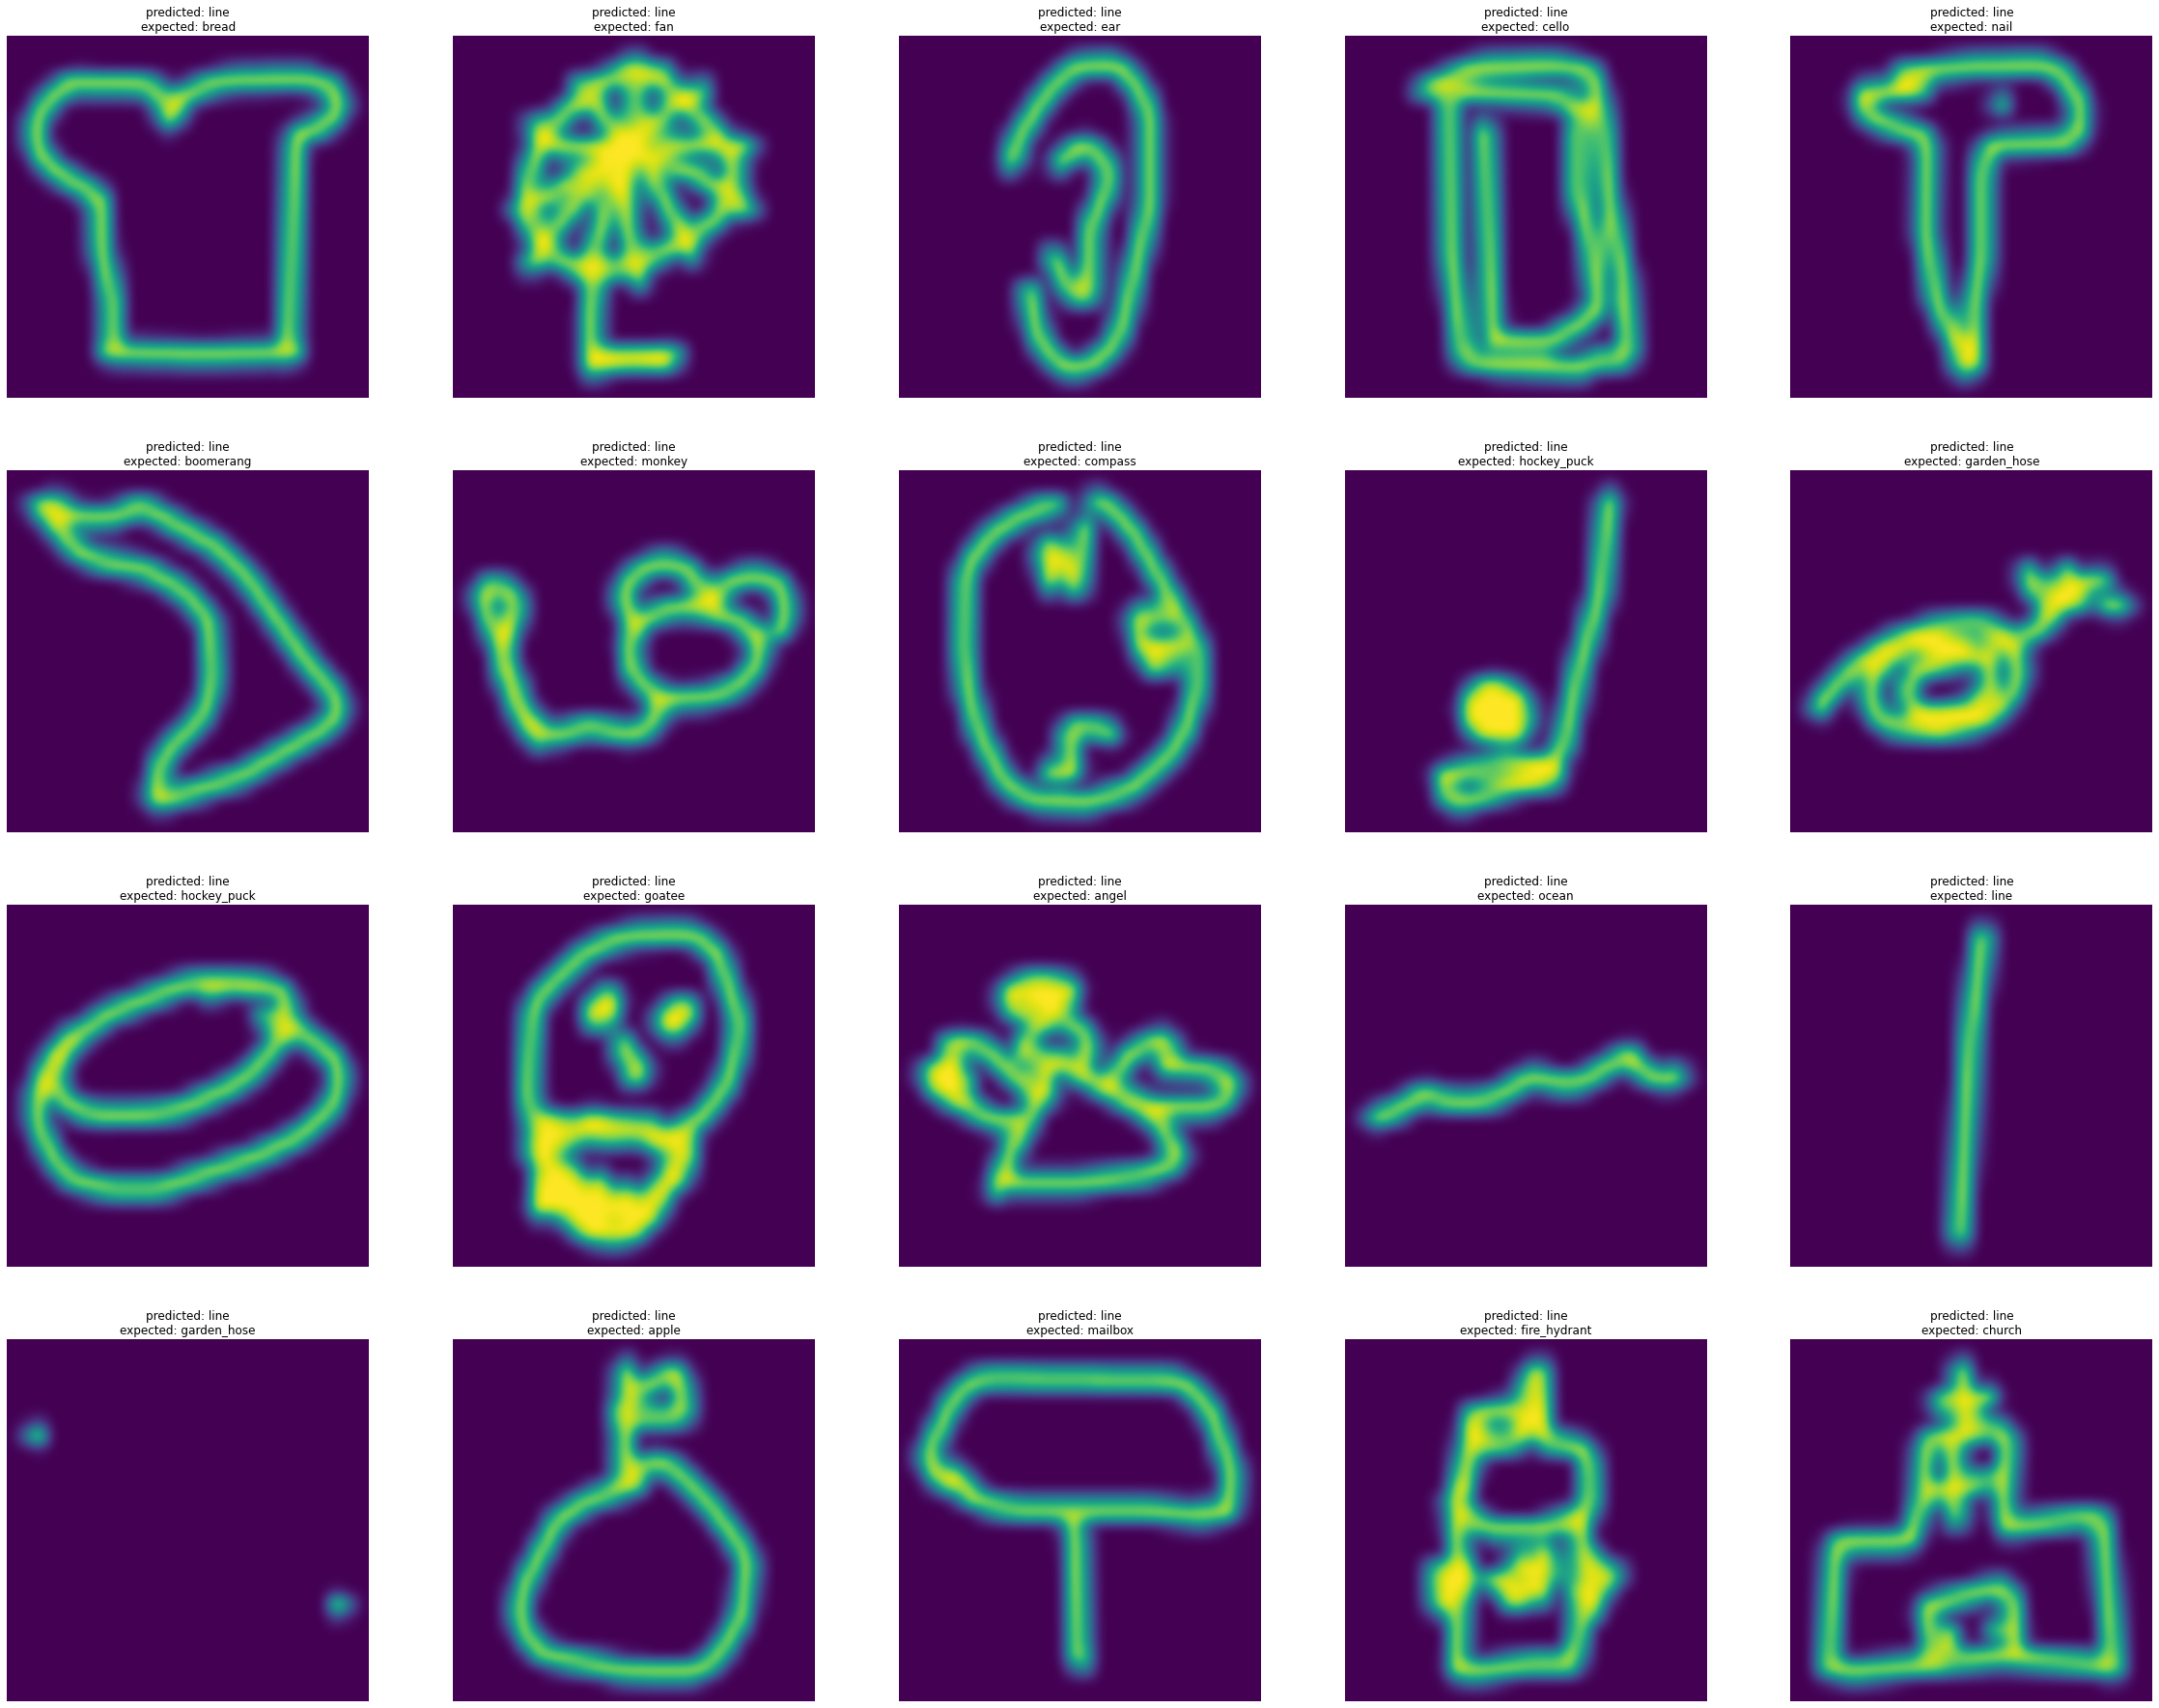

In [12]:
import math
from matplotlib import pyplot as plt

predictions = execution.outputs.get('o0')
feature_list = execution.outputs.get('o1')
label_list = execution.outputs.get('o2')

# Arrange results in a square where each image contains the prediction alongside with the original label
fig = plt.figure(figsize=(40, 40))

sqr = math.sqrt(len(predictions))
rows = math.ceil(sqr)
columns = math.floor(sqr) + 1

for i in range(len(predictions)):
    best_prediction = max(predictions[i], key=predictions[i].get)
    expected_label = label_list[i]

    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(feature_list[i], interpolation='bicubic')
    plt.axis('off')
    plt.title(f"predicted: {best_prediction}\nexpected: {expected_label}")